# Classificação - Dados Abertos da PRF

## Carregando as bibliotecas

In [ ]:
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sns

## Carregando o dataset

In [2]:
datatran2025 = pd.read_csv(
    "../dataset/prf/datatran2025.csv",
    sep		 = ";",
    encoding = "latin1"
)

In [3]:
datatran2025.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28598 entries, 0 to 28597
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id                      28598 non-null  int64 
 1   data_inversa            28598 non-null  object
 2   dia_semana              28598 non-null  object
 3   horario                 28598 non-null  object
 4   uf                      28598 non-null  object
 5   br                      28598 non-null  int64 
 6   km                      28598 non-null  object
 7   municipio               28598 non-null  object
 8   causa_acidente          28598 non-null  object
 9   tipo_acidente           28597 non-null  object
 10  classificacao_acidente  28596 non-null  object
 11  fase_dia                28598 non-null  object
 12  sentido_via             28598 non-null  object
 13  condicao_metereologica  28598 non-null  object
 14  tipo_pista              28598 non-null  object
 15  tr

In [4]:
datatran2025.shape

(28598, 30)

## Preprocessamento do dataset

Removendo linhas com valores vazios

In [5]:
datatran2025 = datatran2025.dropna()

In [6]:
datatran2025.shape

(28584, 30)

Selecionando colunas que parecem relevantes

In [7]:
datatran2025 = datatran2025[[
    'dia_semana', 
    'tipo_acidente',
    'fase_dia', 
    'condicao_metereologica',
    'veiculos',
    'feridos'
]]

In [8]:
datatran2025.sample(10)

,dia_semana,tipo_acidente,fase_dia,condicao_metereologica,veiculos,feridos
20589,terça-feira,Colisão lateral mesmo sentido,Pleno dia,Céu Claro,3,1
18758,terça-feira,Atropelamento de Pedestre,Plena Noite,Garoa/Chuvisco,2,1
19103,sexta-feira,Tombamento,Pleno dia,Céu Claro,1,1
7419,terça-feira,Colisão transversal,Amanhecer,Nublado,3,1
27008,quinta-feira,Colisão transversal,Pleno dia,Sol,2,1
9349,quinta-feira,Colisão traseira,Pleno dia,Céu Claro,2,1
24537,segunda-feira,Colisão com objeto,Anoitecer,Nublado,2,1
13517,domingo,Colisão transversal,Pleno dia,Céu Claro,2,1
12569,domingo,Colisão lateral mesmo sentido,Pleno dia,Céu Claro,3,7
8970,segunda-feira,Queda de ocupante de veículo,Pleno dia,Céu Claro,1,1


Simplificação dos tipos de acidente

In [9]:
def simplificarTiposAcidentes(tipo):
	atropelamento = [
		'Atropelamento de Animal',
		'Atropelamento de Pedestre'
	]

	colisao = [
		'Colisão com objeto', 
		'Colisão frontal', 
		'Colisão lateral mesmo sentido',
		'Colisão lateral sentido oposto', 
		'Colisão transversal', 
		'Colisão traseira'
	]

	tombamento = [
		'Tombamento',
		'Derramamento de carga'	
	]

	if tipo in atropelamento:
		return 'Atropelamento'

	if tipo in colisao:
		return 'Colisão'
	
	if tipo in tombamento:
		return 'Tombamento'

	return tipo

datatran2025['tipo_acidente'] = datatran2025['tipo_acidente'].apply(simplificarTiposAcidentes)


In [10]:
datatran2025.head(10)

,dia_semana,tipo_acidente,fase_dia,condicao_metereologica,veiculos,feridos
0,quarta-feira,Tombamento,Pleno dia,Céu Claro,2,1
1,quarta-feira,Colisão,Pleno dia,Céu Claro,6,1
2,quarta-feira,Colisão,Pleno dia,Sol,2,3
3,quarta-feira,Saída de leito carroçável,Pleno dia,Céu Claro,2,1
4,quarta-feira,Colisão,Pleno dia,Chuva,4,2
5,quarta-feira,Colisão,Pleno dia,Céu Claro,5,0
6,quarta-feira,Saída de leito carroçável,Pleno dia,Céu Claro,2,1
7,quarta-feira,Colisão,Pleno dia,Nublado,2,1
8,quarta-feira,Tombamento,Anoitecer,Nublado,2,0
9,quarta-feira,Incêndio,Pleno dia,Céu Claro,1,0


Definindo a ordem dos dias da semana

In [11]:
ordemDosDias = [
    'domingo'       , 
    'segunda-feira' , 
    'terça-feira'   , 
    'quarta-feira'  ,
    'quinta-feira'  ,  
    'sexta-feira'   , 
    'sábado'
]


In [12]:
datatran2025['dia_semana'] = pd.Categorical(
    values     = datatran2025['dia_semana'],
    categories = ordemDosDias,
    ordered    = True
)


## Analise Exploratória

Verificando a proporção das classes

In [13]:
datatran2025['tipo_acidente'].value_counts(normalize = True)

tipo_acidente
Colisão                         0.600861
Saída de leito carroçável       0.140813
Tombamento                      0.089211
Atropelamento                   0.056990
Queda de ocupante de veículo    0.048629
Incêndio                        0.023545
Capotamento                     0.019521
Engavetamento                   0.016338
Eventos atípicos                0.004023
Sinistro pessoal de trânsito    0.000070
Name: proportion, dtype: float64

Distribuição percentual dos grupos de acidente

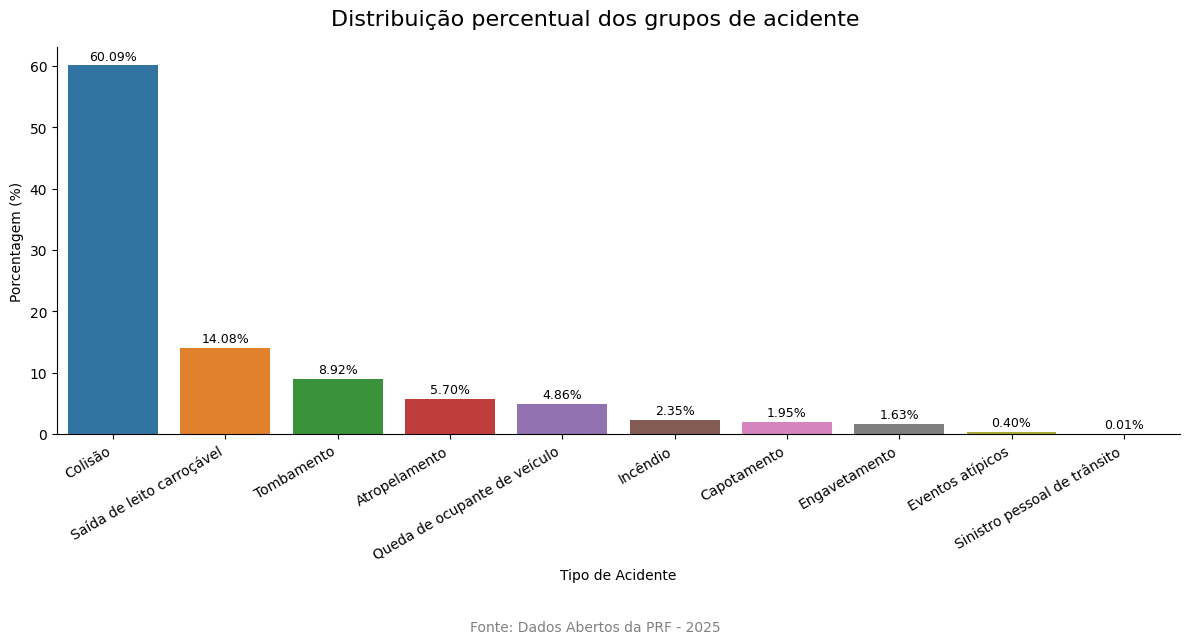

In [14]:
tipoAcidenteCounts = (
    datatran2025['tipo_acidente']
    .value_counts(normalize = True)
    .reset_index()
)
tipoAcidenteCounts.columns     = ['tipo_acidente', 'percent']
tipoAcidenteCounts['percent'] *= 100

g = sns.catplot(
    data    = tipoAcidenteCounts,
    x       = 'tipo_acidente',
    y       = 'percent',
    kind    = 'bar',
    hue     = 'tipo_acidente',
    palette = "tab10",
    aspect  = 2,
    height  = 6
)

g.figure.suptitle(
    "Distribuição percentual dos grupos de acidente", 
    fontsize = 16
)
g.figure.text(
    0.5, -0.05,
    "Fonte: Dados Abertos da PRF - 2025", 
    ha 		 = 'center', 
    va 		 = 'center', 
    fontsize = 10, 
    color    = 'gray'
)
g.figure.subplots_adjust(top=0.92)

g.set_axis_labels("Tipo de Acidente", "Porcentagem (%)")
g.set_xticklabels(rotation = 30, ha = 'right')

for ax in g.axes.flat:
    for container in ax.containers:
        ax.bar_label(
            container,
            labels   = [f"{bar.get_height():.2f}%" for bar in container],
            padding  = 2,
            fontsize = 9,
            label_type='edge'
        )

plt.tight_layout()
plt.show()


Tabela cruzada entre Tipo de acidente e a condicão metereológica

In [15]:
pd.crosstab(
	index        = datatran2025['tipo_acidente'], 
	columns      = datatran2025['condicao_metereologica'], 
	normalize    = "index", 
    margins      = True,
    margins_name = "Total"
).map(lambda x: f"{x * 100:.2f}%")

condicao_metereologica,Chuva,Céu Claro,Garoa/Chuvisco,Ignorado,Nevoeiro/Neblina,Nublado,Sol,Vento
tipo_acidente,,,,,,,,
Atropelamento,6.51%,65.38%,3.01%,1.72%,0.74%,19.09%,3.31%,0.25%
Capotamento,19.00%,55.38%,5.56%,1.61%,0.54%,14.16%,3.58%,0.18%
Colisão,7.66%,64.75%,3.02%,1.21%,0.61%,16.35%,6.31%,0.10%
Engavetamento,9.64%,60.81%,2.36%,0.86%,0.64%,15.42%,10.28%,0.00%
Eventos atípicos,6.09%,68.70%,4.35%,2.61%,0.87%,11.30%,5.22%,0.87%
Incêndio,3.86%,68.95%,2.23%,1.63%,0.74%,17.38%,4.75%,0.45%
Queda de ocupante de veículo,7.91%,65.61%,3.38%,1.65%,0.50%,15.40%,5.40%,0.14%
Saída de leito carroçável,19.83%,52.84%,4.22%,1.42%,0.92%,16.02%,4.65%,0.10%
Sinistro pessoal de trânsito,0.00%,100.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%


Distribuição percentual dos tipos de acidente por condição meteorológica

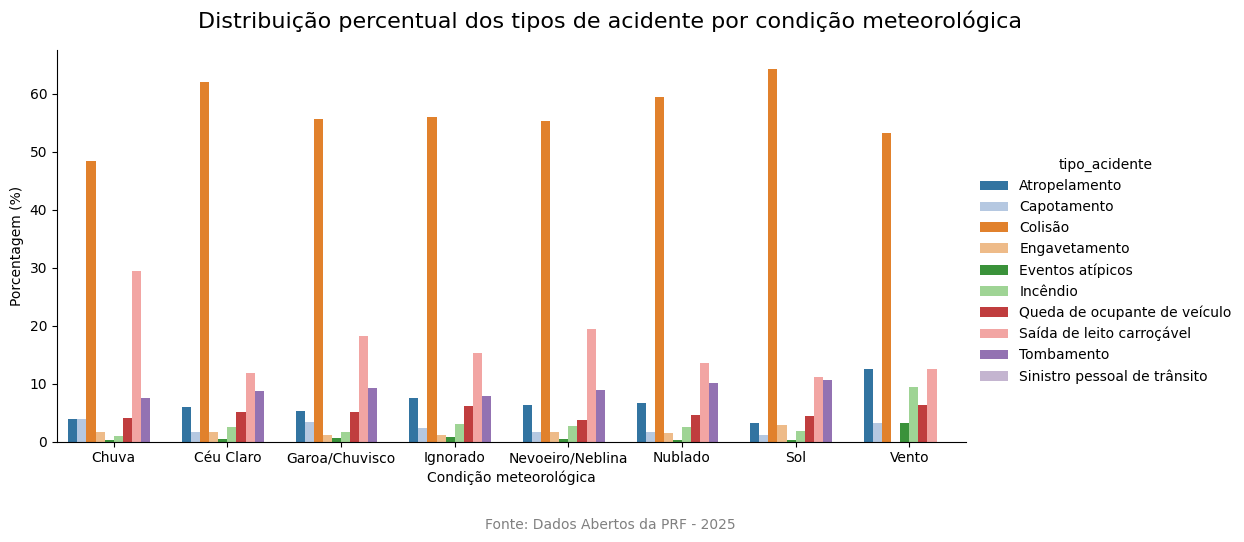

In [16]:
metereologicaAcidenteGroupCounts = (
    datatran2025
    .groupby(['condicao_metereologica', 'tipo_acidente'])
    .size()
    .reset_index(name = 'count')
)

metereologicaAcidenteGroupCounts['percent'] = (
    metereologicaAcidenteGroupCounts
    .groupby('condicao_metereologica')['count']
    .transform(lambda x: 100 * x / x.sum())
)

g = sns.catplot(
    data 	= metereologicaAcidenteGroupCounts,
    x	 	= 'condicao_metereologica',
    y	 	= 'percent',
    hue	 	= 'tipo_acidente',
    kind 	= 'bar',
    palette = "tab20",
    aspect	= 2
)

g.figure.suptitle(
    "Distribuição percentual dos tipos de acidente por condição meteorológica", 
    fontsize = 16
)
g.figure.text(
    0.5, 
    -0.05,
    "Fonte: Dados Abertos da PRF - 2025", 
    ha 		 = 'center', 
    va 		 = 'center', 
    fontsize = 10, 
    color    = 'gray'
)
g.figure.subplots_adjust(top = 0.90)
g.set_axis_labels("Condição meteorológica", "Porcentagem (%)")

Tabela cruzada entre Tipo de acidente e o dia da semana

In [17]:
pd.crosstab(
	index        = datatran2025['tipo_acidente'], 
	columns      = datatran2025['dia_semana'], 
	normalize    = "index", 
    margins      = True,
    margins_name = "Total"
).map(lambda x: f"{x * 100:.2f}%")

dia_semana,domingo,segunda-feira,terça-feira,quarta-feira,quinta-feira,sexta-feira,sábado
tipo_acidente,,,,,,,
Atropelamento,14.73%,14.55%,11.72%,14.18%,13.75%,14.12%,16.94%
Capotamento,19.89%,13.08%,8.78%,12.19%,11.65%,15.95%,18.46%
Colisão,14.17%,14.22%,12.42%,13.82%,13.67%,16.27%,15.44%
Engavetamento,10.06%,18.20%,12.42%,13.70%,14.56%,17.13%,13.92%
Eventos atípicos,17.39%,8.70%,15.65%,17.39%,12.17%,15.65%,13.04%
Incêndio,12.78%,13.82%,14.71%,13.97%,12.18%,16.94%,15.60%
Queda de ocupante de veículo,17.70%,13.02%,13.67%,12.23%,13.38%,13.09%,16.91%
Saída de leito carroçável,20.35%,13.42%,9.64%,12.27%,11.50%,13.61%,19.20%
Sinistro pessoal de trânsito,50.00%,0.00%,0.00%,0.00%,0.00%,0.00%,50.00%


Distribuição percentual dos tipos de acidente por dia da semana

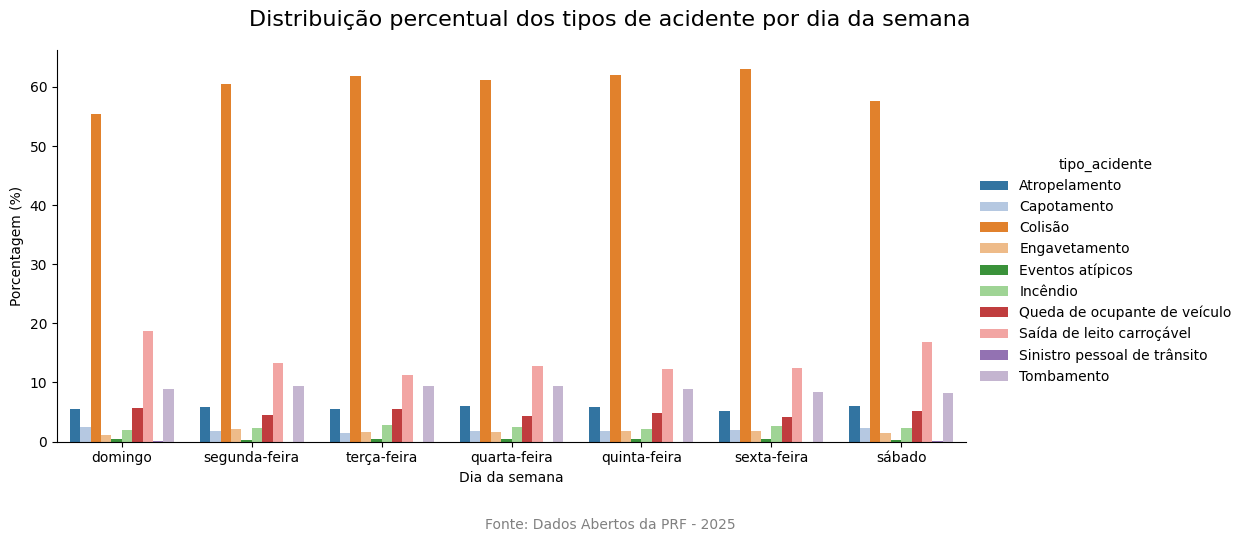

In [18]:
diaSemanaAcidenteGroupCounts = (
    datatran2025
    .groupby(['dia_semana', 'tipo_acidente'], observed = False)
    .size()
    .reset_index(name = 'count')
)

diaSemanaAcidenteGroupCounts['percent'] = (
    diaSemanaAcidenteGroupCounts
    .groupby('dia_semana', observed = False)['count']
    .transform(lambda x: 100 * x / x.sum())
)

g = sns.catplot(
    data 	= diaSemanaAcidenteGroupCounts,
    x	 	= 'dia_semana',
    y	 	= 'percent',
    hue	 	= 'tipo_acidente',
    kind 	= 'bar',
    palette = "tab20",
    aspect	= 2
)

g.figure.suptitle(
    "Distribuição percentual dos tipos de acidente por dia da semana", 
    fontsize = 16
)
g.figure.text(
    0.5, 
    -0.05,
    "Fonte: Dados Abertos da PRF - 2025", 
    ha 		 = 'center', 
    va 		 = 'center', 
    fontsize = 10, 
    color    = 'gray'
)
g.figure.subplots_adjust(top = 0.90)
g.set_axis_labels("Dia da semana", "Porcentagem (%)")

Tabela cruzada entre Tipo de acidente e a fase do dia

In [19]:
pd.crosstab(
	index        = datatran2025['tipo_acidente'], 
	columns      = datatran2025['fase_dia'], 
	normalize    = "index", 
    margins      = True,
    margins_name = "Total"
).map(lambda x: f"{x * 100:.2f}%")

fase_dia,Amanhecer,Anoitecer,Plena Noite,Pleno dia
tipo_acidente,,,,
Atropelamento,5.52%,4.85%,60.71%,28.91%
Capotamento,6.09%,4.48%,37.63%,51.79%
Colisão,3.96%,5.94%,31.04%,59.06%
Engavetamento,2.14%,4.71%,19.06%,74.09%
Eventos atípicos,4.35%,4.35%,33.91%,57.39%
Incêndio,5.20%,4.75%,35.07%,54.98%
Queda de ocupante de veículo,3.24%,5.04%,32.52%,59.21%
Saída de leito carroçável,8.00%,4.07%,35.38%,52.55%
Sinistro pessoal de trânsito,0.00%,0.00%,50.00%,50.00%


Distribuição percentual dos tipos de acidente por fase do dia

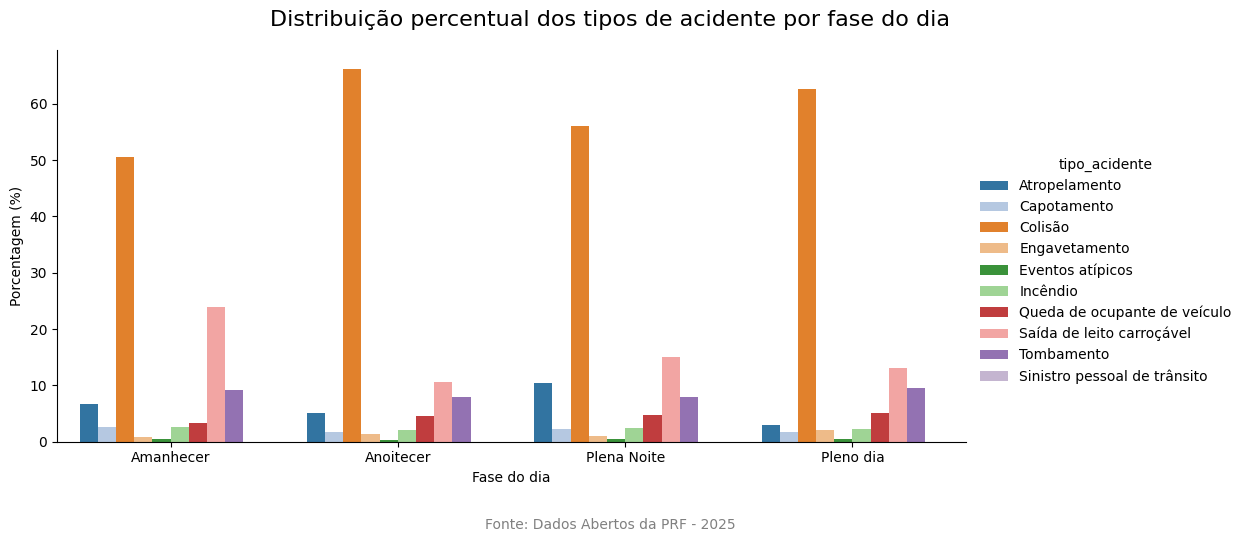

In [20]:
faseDiaAcidenteGroupCounts = (
    datatran2025
    .groupby(['fase_dia', 'tipo_acidente'])
    .size()
    .reset_index(name = 'count')
)

faseDiaAcidenteGroupCounts['percent'] = (
    faseDiaAcidenteGroupCounts
    .groupby('fase_dia')['count']
    .transform(lambda x: 100 * x / x.sum())
)

g = sns.catplot(
    data 	= faseDiaAcidenteGroupCounts,
    x	 	= 'fase_dia',
    y	 	= 'percent',
    hue	 	= 'tipo_acidente',
    kind 	= 'bar',
    palette = "tab20",
    aspect	= 2
)

g.figure.suptitle(
    "Distribuição percentual dos tipos de acidente por fase do dia", 
    fontsize = 16
)
g.figure.text(
    0.5, 
    -0.05,
    "Fonte: Dados Abertos da PRF - 2025", 
    ha 		 = 'center', 
    va 		 = 'center', 
    fontsize = 10, 
    color    = 'gray'
)
g.figure.subplots_adjust(top = 0.90)
g.set_axis_labels("Fase do dia", "Porcentagem (%)")

Média de veículos por tipo de acidente

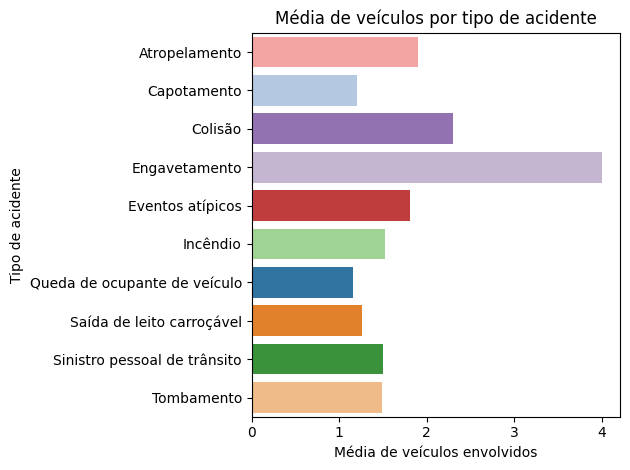

In [21]:
mediaVeiculos = datatran2025.groupby("tipo_acidente")["veiculos"].mean().reset_index()

sns.barplot(
    data    = mediaVeiculos,
    x       = "veiculos",
    y       = "tipo_acidente",
    hue     = 'veiculos',
    legend  = False,
    palette = "tab20"
)

plt.xlabel("Média de veículos envolvidos")
plt.ylabel("Tipo de acidente")

plt.title("Média de veículos por tipo de acidente")

plt.tight_layout()

plt.show()
plt.close()


Média de feridos por tipo de acidente

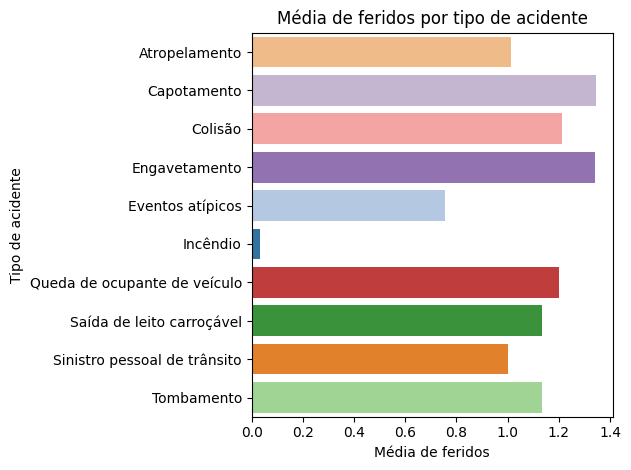

In [22]:
mediaFeridos = datatran2025.groupby("tipo_acidente")["feridos"].mean().reset_index()

sns.barplot(
    data	= mediaFeridos,
    x		= "feridos",
    y		= "tipo_acidente",
    hue 	= 'feridos',
    legend  = False,
    palette = "tab20"
)

plt.xlabel("Média de feridos")
plt.ylabel("Tipo de acidente")

plt.title("Média de feridos por tipo de acidente")

plt.tight_layout()

plt.show()
plt.close()


## Hold out do dataset

## Treinamento do modelo

## Teste do modelo